## Import Libraries and Data

In [4]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_14-17-08-23.csv', firstRow=756, lastRow=762)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_140823_S757-762.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [5]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=106s and ended at t=524s; mass=44.5477g
This equals a volume of 44.637m; expected was 44.923mL; error is 0.637%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


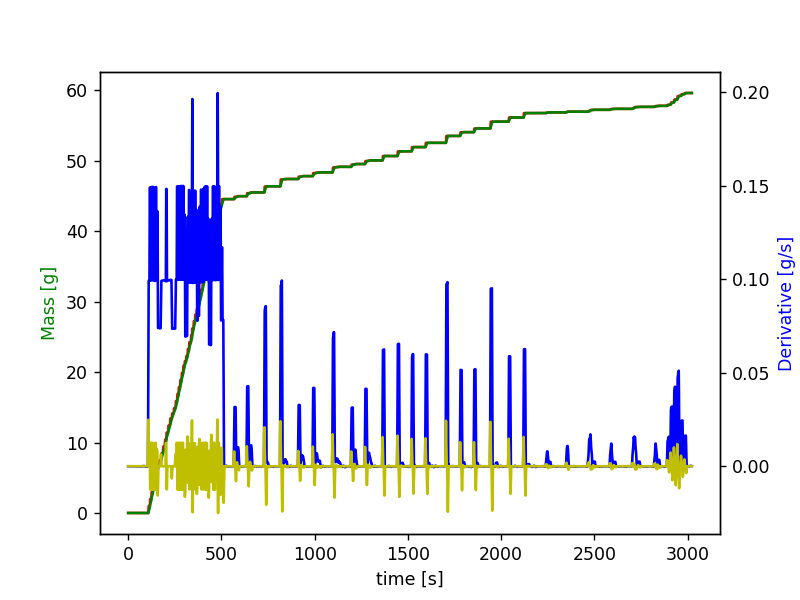

Addition of 0.417g Texapon SB 3 KC detected from 564s to 600s - expected volume = 0.544mL and actual volume = 0.376mL (resulting error is 30.846%)
Addition of 0.537g Texapon SB 3 KC detected from 632s to 670s - expected volume = 0.544mL and actual volume = 0.485mL (resulting error is 10.962%)
Addition of 0.873g Plantapon ACG 50 detected from 726s to 758s - expected volume = 0.849mL and actual volume = 0.776mL (resulting error is 8.651%)
Addition of 1.044g Plantapon ACG 50 detected from 812s to 858s - expected volume = 0.856mL and actual volume = 0.915mL (resulting error is 6.847%)
Addition of 0.413g Plantapon LC 7 detected from 908s to 950s - expected volume = 0.519mL and actual volume = 0.389mL (resulting error is 25.064%)
Addition of 0.528g Plantapon LC 7 detected from 986s to 1036s - expected volume = 0.519mL and actual volume = 0.497mL (resulting error is 4.211%)
Addition of 0.796g Plantacare 2000 detected from 1092s to 1144s - expected volume = 0.855mL and actual volume = 0.728mL 

In [6]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>


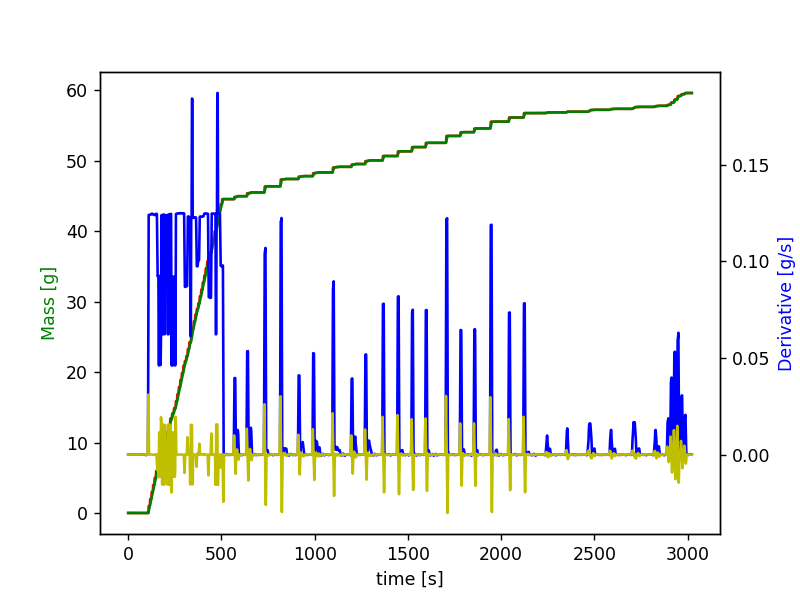

Addition of 0.1g Dehyquart CC7 Benz detected from 2236s to 2270s - expected volume = 0.11mL and actual volume = 0.098mL (resulting error is 10.937%)
Addition of 0.106g Dehyquart CC7 Benz detected from 2344s to 2366s - expected volume = 0.119mL and actual volume = 0.105mL (resulting error is 12.087%)
Addition of 0.272g Dehyquart CC7 Benz detected from 2460s to 2508s - expected volume = 0.253mL and actual volume = 0.27mL (resulting error is 6.939%)
Addition of 0.142g Dehyquart CC7 Benz detected from 2578s to 2618s - expected volume = 0.136mL and actual volume = 0.14mL (resulting error is 3.17%)
Addition of 0.284g Dehyquart CC7 Benz detected from 2698s to 2748s - expected volume = 0.277mL and actual volume = 0.282mL (resulting error is 1.747%)
Addition of 0.153g Dehyquart CC7 Benz detected from 2816s to 2854s - expected volume = 0.151mL and actual volume = 0.151mL (resulting error is 0.406%)


In [7]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2152,2256,2366,2482,2582,2680,2758])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


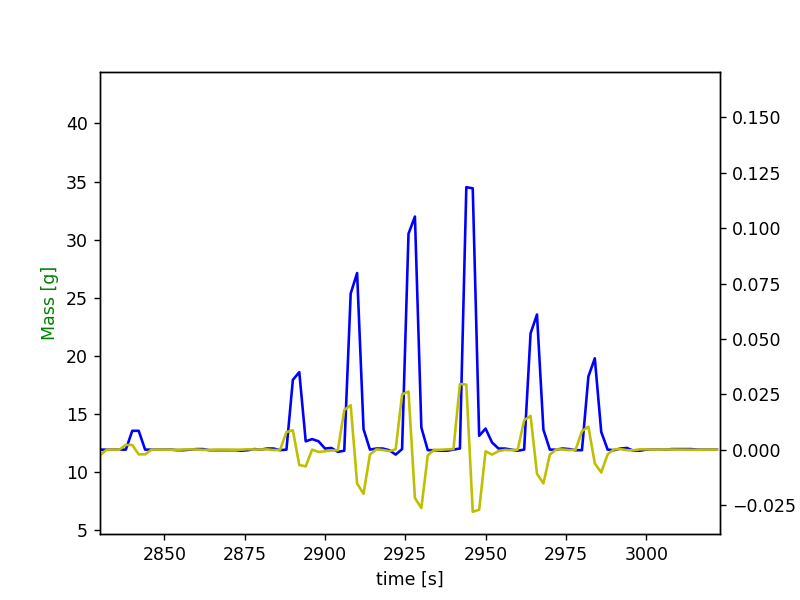

Addition of 0.158g Arlypon TT detected from 2886s to 2898s - expected volume = 0.182mL and actual volume = 0.164mL (resulting error is 9.714%)
Addition of 0.319g Arlypon TT detected from 2904s to 2918s - expected volume = 0.338mL and actual volume = 0.332mL (resulting error is 1.692%)
Addition of 0.419g Arlypon TT detected from 2922s to 2936s - expected volume = 0.412mL and actual volume = 0.44mL (resulting error is 6.888%)
Addition of 0.513g Arlypon TT detected from 2940s to 2956s - expected volume = 0.512mL and actual volume = 0.533mL (resulting error is 4.268%)
Addition of 0.245g Arlypon TT detected from 2960s to 2974s - expected volume = 0.202mL and actual volume = 0.257mL (resulting error is 27.604%)
Addition of 0.165g Arlypon TT detected from 2978s to 2992s - expected volume = 0.13mL and actual volume = 0.17mL (resulting error is 31.6%)


In [8]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2490,2506,2522,2538,2554,2568,2588])

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_140823_S757-S756.csv', index=False)
actualMassFractions